# OLS - Linear Regression Models Notebook
This notebook is for making first models using dataset ES_0.  
3 linear reg models to get information about the data to make AR models.

#### Objective:
1. make models progressively adding information as covariables:
    1. mean and sd
    2. ols - hour and month dummies
    3. ols - hour transformed and month dummies 
    4. ols - hour transformed and month information as sin and cos

### Proposal notebook structure:
1. Imports and adding non-stocastic covariables
2. Declaring X and Y to each model
3. Model making: for each model
    1. Create X from each of the models
    1. metrics
    2. errors graphs
    3. acf and pacf errors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os
import seaborn as sns
sns.set()

figsize = (20,7)
figsize2 = (20,5)

import os
directory = '../input/hourly-weather-surface-brazil-southeast-region/'
os.chdir(directory)
import make_dataset as mk

## 1. Importing and adding basic covariables

In [2]:
df_raw = pd.read_csv('southeast.csv')
stations = ['A612']
start_date = '2006-11-01'
df = mk.make_dataset(stations, start_date, df_raw)
df_raw = None

In [3]:
## adding covariables
df['hour'] = df.date_time.dt.hour
df['month'] = df.date_time.dt.month
df['year'] = df.date_time.dt.year
df['day_of_year'] = df.date_time.dt.day_of_year
df['weekofyear'] = df.date_time.dt.weekofyear

## transforming start hour in 9, to use hour**3, some models are hierarchical so is necessary to keep hour**2 
df['hour_9'] = df['hour'].apply(lambda x: (x-9)%24)
df['hour_9**2'] = df['hour_9']**2
df['hour_9**3'] = df['hour_9']**3

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


# 2 - Declaring x and y to be used

In [4]:
## preprocessing + covariables
def create_sincos_year_array(n,start_date,end_date,n_days_in_year = 366):
    start_date = pd.to_datetime(start_date)
    end_date   = pd.to_datetime(end_date)
    
    ## day distance
    first_date = pd.to_datetime('{year}-01-01'.format(year = start_date.year))
    day_of_the_year_start = (start_date - first_date).days
        
    ## year distance
    distance = (end_date - first_date).days
    
    ##
    start = (np.pi*2)*(day_of_the_year_start/n_days_in_year)
    end = np.pi*2*(distance/n_days_in_year)
    
    length = np.arange(start, end, (end-start)/n)
    df =  pd.concat([pd.Series(np.sin(length)),pd.Series(np.cos(length))],axis=1)
    df.columns = ['sin_year','cos_year']
    return df

def make_dummies(series):
    df = pd.get_dummies(series,drop_first=True)
    df.columns = list(map(lambda x: '{}_'.format(series.name) + str(x),list(df.columns)))
    return df

#### Y

In [5]:
## setting target variables to be easy to call later
y1,y2,y3 = 'A612_prcp','A612_tmax','A612_tmin'# 'A612 - total precipitation (mm)' "max temp" "min temp"

## 2. Transformed hour model

### X

In [6]:
## For all
df_model = df[df.date_time < '01-01-2020']
df_model = pd.concat([df_model,create_sincos_year_array(df_model.shape[0], df_model.date_time.max(), df_model.date_time.min(), n_days_in_year=366)],axis=1)
_y_ = df_model[[y1,y2,y3]]

In [7]:
x = df_model.iloc[:,-10:]
x['hour'] = df_model.hour
x = x.drop(['day_of_year','weekofyear','year'],axis=1)

In [8]:
## 1 just dummies model
x_dummy = pd.concat([x,make_dummies(x['hour'])],axis=1)
x_dummy = pd.concat([x_dummy,make_dummies(x['month'])],axis=1)
x_dummy.drop(['month', 'hour_9', 'hour_9**2', 'hour_9**3', 'hour', 'sin_year', 'cos_year'],axis=1,inplace=True)
x_dummy['intercept'] = 1

In [9]:
## 2 month dummies and hour transformed
x_hour_9 = pd.concat([x,make_dummies(x['month'])],axis=1)
x_hour_9.drop(['month', 'hour', 'sin_year', 'cos_year'],axis=1,inplace=True)
x_hour_9['intercept'] = 1

In [10]:
## 3 hour transformed and sin and cos
x_no_dummies = df_model.loc[:,['hour_9', 'hour_9**2', 'hour_9**3','sin_year', 'cos_year']]
x_no_dummies['intercept'] = 1

---
# Linear Regression Models

In [11]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from metrics import create_metrics

In [12]:
def ols_model(x, y, codename=None):
    if codename == None:
        codename = f'{ x.shape[1] }_{ y.name.split(" ")[2] }'
        
    x_train, x_test = x[df_model.date_time<'01-01-2018'], x[df_model.date_time>='01-01-2018']
    y_train, y_test = y[df_model.date_time<'01-01-2018'], y[df_model.date_time>='01-01-2018']
    
    model = OLS(y_train,x_train)
    fit = model.fit()
    y_pred = fit.predict(x_test)
    
    metrics = create_metrics(y_test,y_pred)
    return {'y_pred': y_pred, 'fit': fit, 'model':model, 'metrics':metrics, 'codename': codename}

# 3. Models

## 1. Dummies model

In [13]:
model_dummies = ols_model(x_dummy,_y_.iloc[:,2],codename='Dummies')

In [14]:
model_dummies['metrics']

{'mean abs deviation': 2.9074953021726264,
 'mean absolute error': 1.6612933887417982,
 'median abs deviation': 2.400000000000002,
 'median absolute error': 1.3935025540001487}

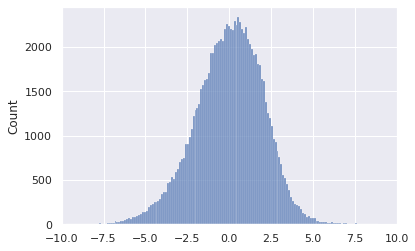

In [15]:
residuals = model_dummies['fit'].resid
plt.xlim(-10,10)
_ = sns.histplot(residuals)

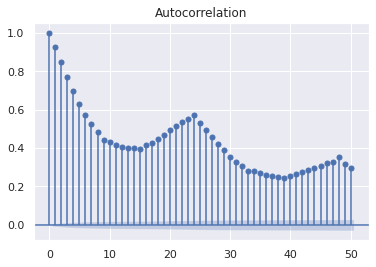

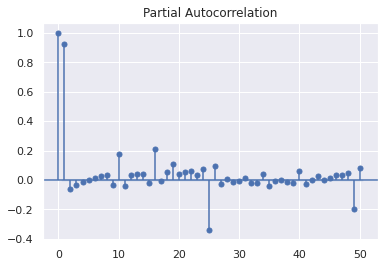

In [16]:
_ = plot_acf(residuals)
_ = plot_pacf(residuals)

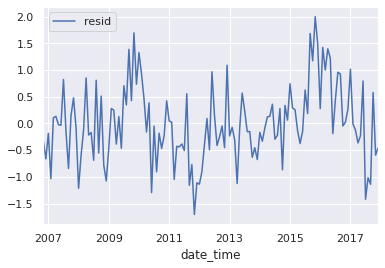

In [17]:
df_plot = pd.DataFrame(df_model.date_time[:len(residuals)])
df_plot['resid'] = residuals
df_plot.index = df_plot.date_time
df_plot.drop('date_time',inplace=True,axis=1)
df_plot = df_plot.resample('M').mean()
_ = df_plot.plot()

## 2. Transformed hour model

In [18]:
model_hour9 = ols_model(x_hour_9,_y_.iloc[:,2], codename='Hour 9')

In [19]:
model_hour9['metrics']

{'mean abs deviation': 2.9074953021726264,
 'mean absolute error': 1.6822048040370476,
 'median abs deviation': 2.400000000000002,
 'median absolute error': 1.3980298037015189}

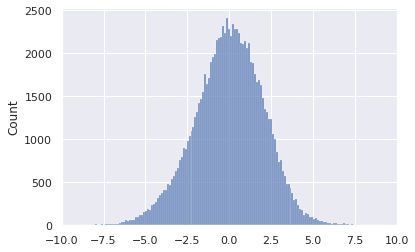

In [20]:
residuals = model_hour9['fit'].resid
plt.xlim(-10,10)
_ = sns.histplot(residuals)

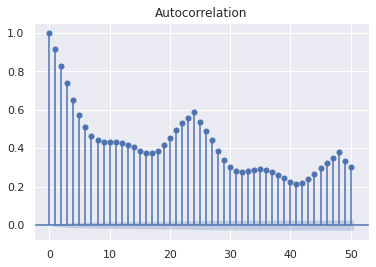

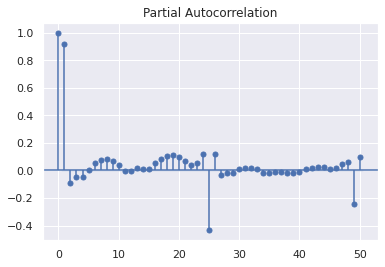

In [21]:
_ = plot_acf(residuals)
_ = plot_pacf(residuals)

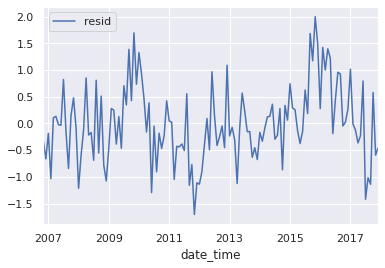

In [22]:
df_plot = pd.DataFrame(df_model.date_time[:len(residuals)])
df_plot['resid'] = residuals
df_plot.index = df_plot.date_time
df_plot.drop('date_time',inplace=True,axis=1)
df_plot = df_plot.resample('M').mean()
_ = df_plot.plot()

## 3. No dummies

In [23]:
model_no_dummies = ols_model(x_no_dummies,_y_.iloc[:,2], codename='No Dummies')

In [24]:
model_no_dummies['metrics']

{'mean abs deviation': 2.9074953021726264,
 'mean absolute error': 1.683338499312467,
 'median abs deviation': 2.400000000000002,
 'median absolute error': 1.3881293302842916}

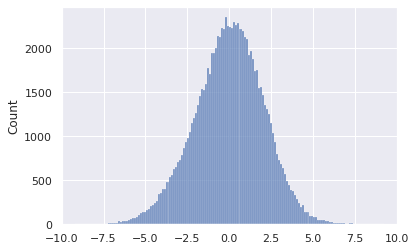

In [25]:
residuals = model_no_dummies['fit'].resid
plt.xlim(-10,10)
_ = sns.histplot(residuals)

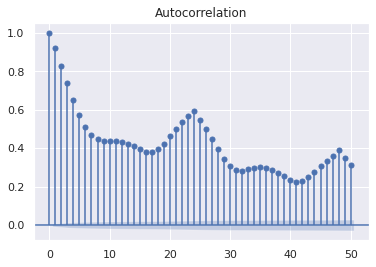

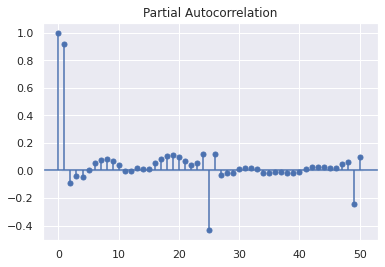

In [26]:
_ = plot_acf(residuals)
_ = plot_pacf(residuals)

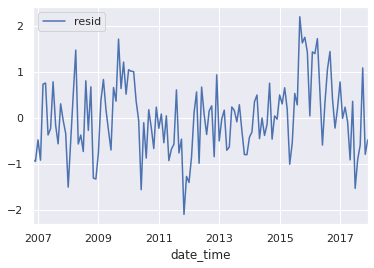

In [27]:
df_plot = pd.DataFrame(df_model.date_time[:len(residuals)])
df_plot['resid'] = residuals
df_plot.index = df_plot.date_time
df_plot.drop('date_time',inplace=True,axis=1)
df_plot = df_plot.resample('M').mean()
_ = df_plot.plot()

## Conclusions

In [28]:
def metrics_dataframe(models,models_names = None):
    vector = []
    lenght = len(models)
    for i in range(lenght):
        vector.append(pd.DataFrame([models[i]['metrics']],index=[models[i]['codename']]))
    return pd.concat(vector)

In [29]:
# names = ['Dummies','No Dummies','Hour9']
models = [model_dummies, model_hour9, model_no_dummies]
metrics_dataframe(models)

,mean abs deviation,mean absolute error,median abs deviation,median absolute error
Dummies,2.907495,1.661293,2.4,1.393503
Hour 9,2.907495,1.682205,2.4,1.398030
No Dummies,2.907495,1.683338,2.4,1.388129
